In [1]:
class TreeNode:
    def __init__(self, item, count, parent):
        self.item = item
        self.count = count
        self.parent = parent
        self.children = {}
        self.link = None  # next node with same item

    def increment(self, count):
        self.count += count

def build_header_table(transactions, min_support):
    item_counts = {}
    for transaction in transactions:
        for item in transaction:
            item_counts[item] = item_counts.get(item, 0) + 1

    header_table = {}
    for item, count in item_counts.items():
        if count >= min_support:
            header_table[item] = [count, None]  # [count, head of node link]
    return header_table

def sort_items(transaction, header_table):
    return sorted(
        [item for item in transaction if item in header_table],
        key=lambda item: (-header_table[item][0], item)
    )

def insert_tree(transaction, node, header_table):
    if not transaction:
        return

    first_item = transaction[0]
    if first_item in node.children:
        node.children[first_item].increment(1)
    else:
        new_node = TreeNode(first_item, 1, node)
        node.children[first_item] = new_node

        # Link header table
        if header_table[first_item][1] is None:
            header_table[first_item][1] = new_node
        else:
            current = header_table[first_item][1]
            while current.link:
                current = current.link
            current.link = new_node

    insert_tree(transaction[1:], node.children[first_item], header_table)

def build_fp_tree(transactions, min_support):
    header_table = build_header_table(transactions, min_support)
    if not header_table:
        return None, None

    root = TreeNode(None, 1, None)

    for transaction in transactions:
        ordered_items = sort_items(transaction, header_table)
        insert_tree(ordered_items, root, header_table)

    return root, header_table

def find_prefix_paths(base_item, node):
    conditional_patterns = []
    while node:
        path = []
        parent = node.parent
        while parent and parent.item:
            path.append(parent.item)
            parent = parent.parent
        if path:
            conditional_patterns.append((list(reversed(path)), node.count))
        node = node.link
    return conditional_patterns

def mine_fp_tree(header_table, prefix, min_support, frequent_patterns):
    sorted_items = sorted(header_table.items(), key=lambda x: x[1][0])
    for item, (count, node) in sorted_items:
        new_pattern = prefix + [item]
        frequent_patterns.append((new_pattern, count))

        conditional_patterns = find_prefix_paths(item, node)
        conditional_transactions = []
        for pattern, count in conditional_patterns:
            conditional_transactions.extend([pattern] * count)

        subtree, sub_header = build_fp_tree(conditional_transactions, min_support)
        if sub_header:
            mine_fp_tree(sub_header, new_pattern, min_support, frequent_patterns)

def fp_growth(transactions, min_support):
    tree, header = build_fp_tree(transactions, min_support)
    frequent_patterns = []
    if header:
        mine_fp_tree(header, [], min_support, frequent_patterns)
    return frequent_patterns

transactions = [
    ['I1', 'I2', 'I5'],
    ['I2', 'I4'],
    ['I2', 'I3'],
    ['I1', 'I2', 'I4'],
    ['I1', 'I3'],
    ['I2', 'I3'],
    ['I1', 'I3'],
    ['I1', 'I2', 'I3', 'I5'],
    ['I1', 'I2', 'I3']
]

min_support = 2
patterns = fp_growth(transactions, min_support)

print("Frequent Patterns:")
for pattern, count in patterns:
    print(f"{pattern}: {count}")

Frequent Patterns:
['I5']: 2
['I5', 'I2']: 2
['I5', 'I2', 'I1']: 2
['I5', 'I1']: 2
['I4']: 2
['I4', 'I2']: 2
['I1']: 6
['I1', 'I2']: 4
['I3']: 6
['I3', 'I2']: 4
['I3', 'I2', 'I1']: 2
['I3', 'I1']: 4
['I2']: 7



FP-Table (after support filtering):
Item: I2, Count: 7
Item: I1, Count: 6
Item: I3, Count: 6
Item: I4, Count: 2
Item: I5, Count: 2

Transaction 1: ['I2', 'I1', 'I5']
Drawing FP-Tree after Transaction 1:


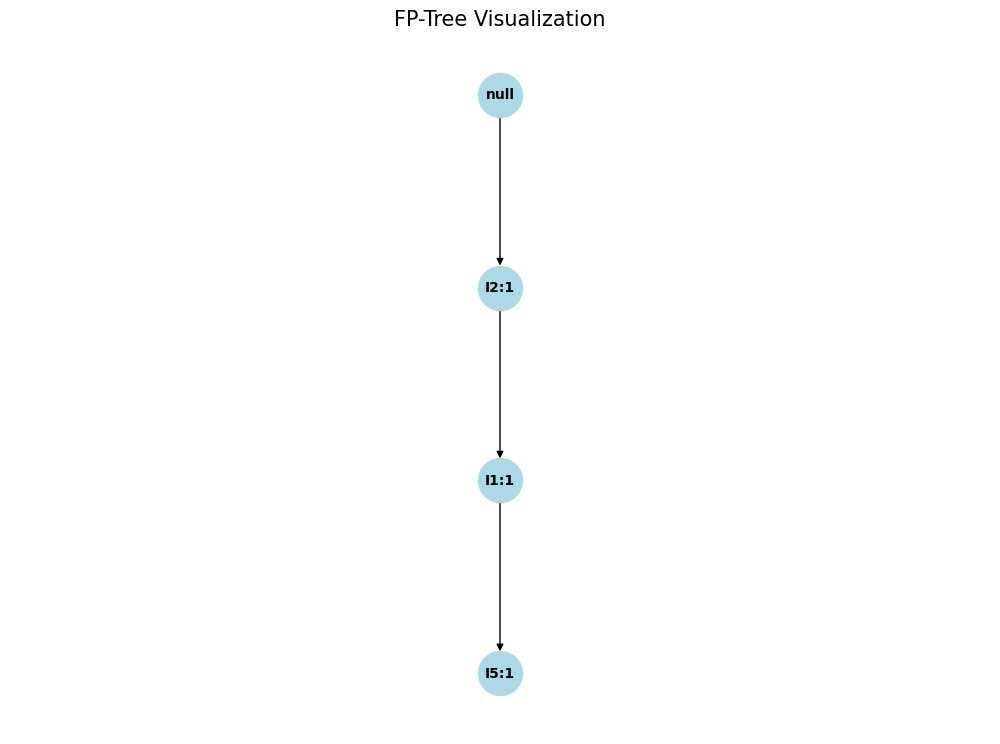


Transaction 2: ['I2', 'I4']
Drawing FP-Tree after Transaction 2:


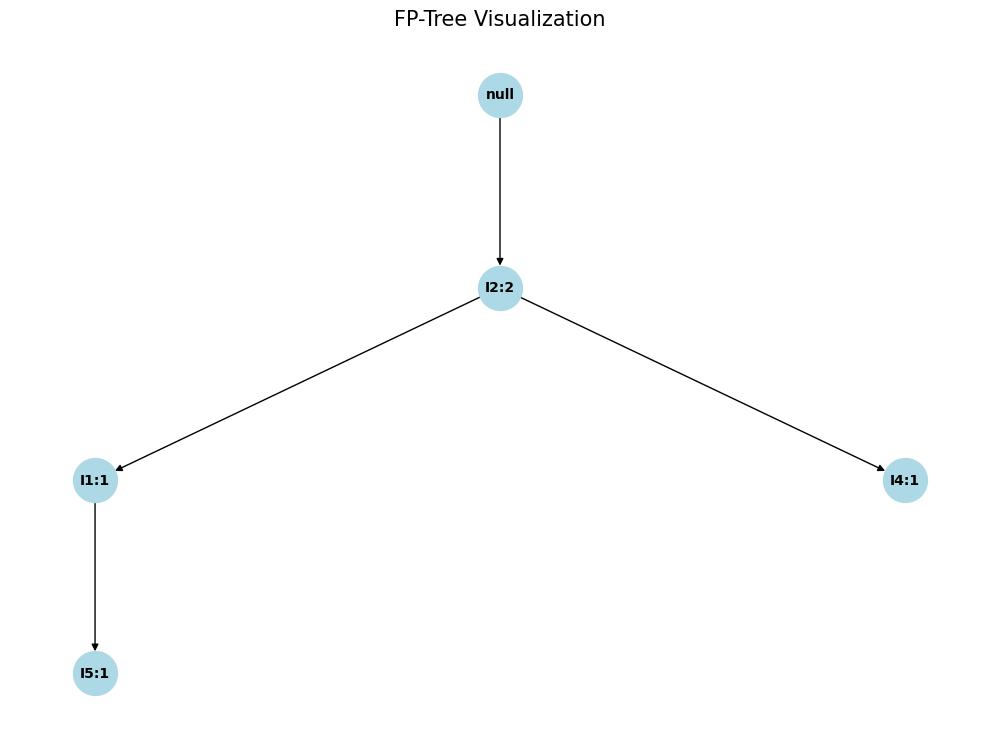


Transaction 3: ['I2', 'I3']
Drawing FP-Tree after Transaction 3:


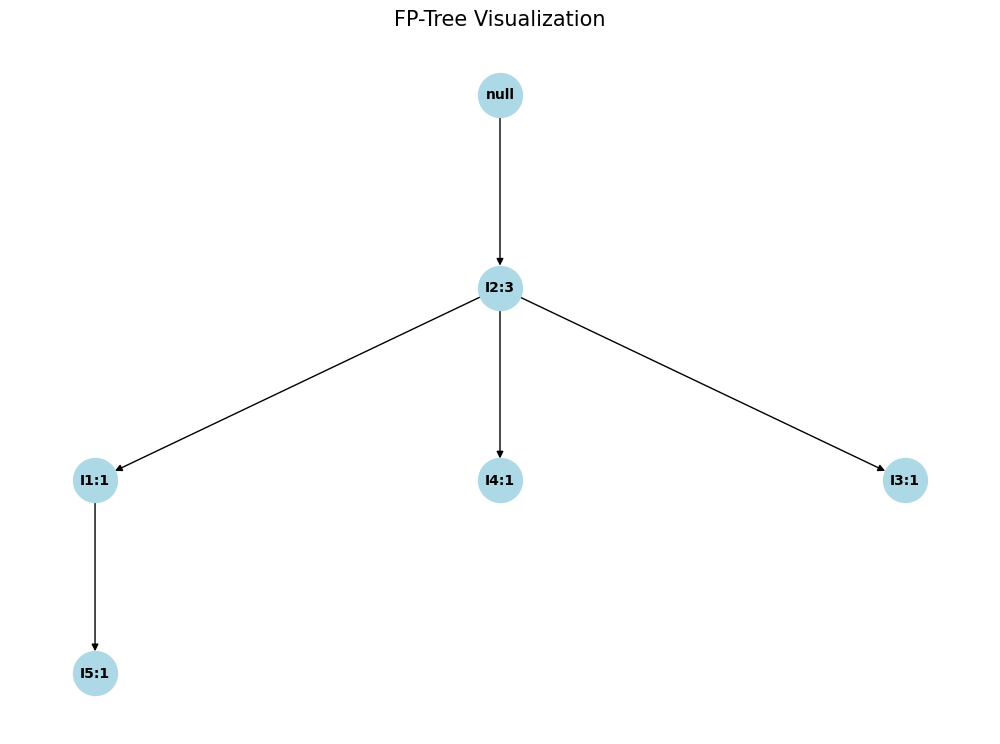


Transaction 4: ['I2', 'I1', 'I4']
Drawing FP-Tree after Transaction 4:


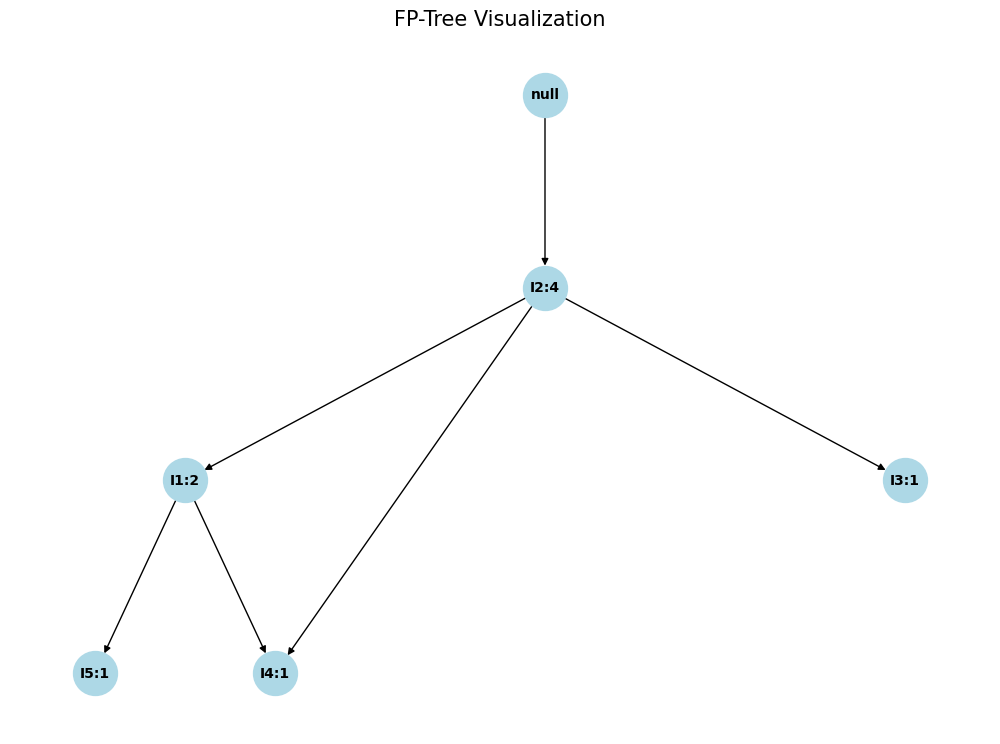


Transaction 5: ['I1', 'I3']
Drawing FP-Tree after Transaction 5:


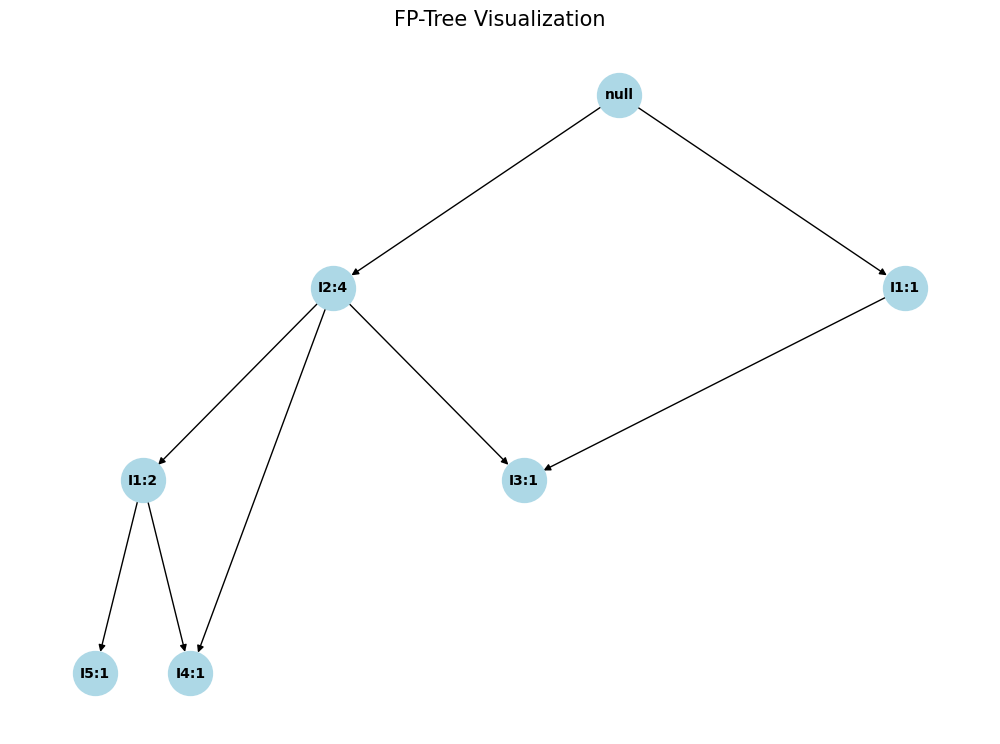


Transaction 6: ['I2', 'I3']
Drawing FP-Tree after Transaction 6:


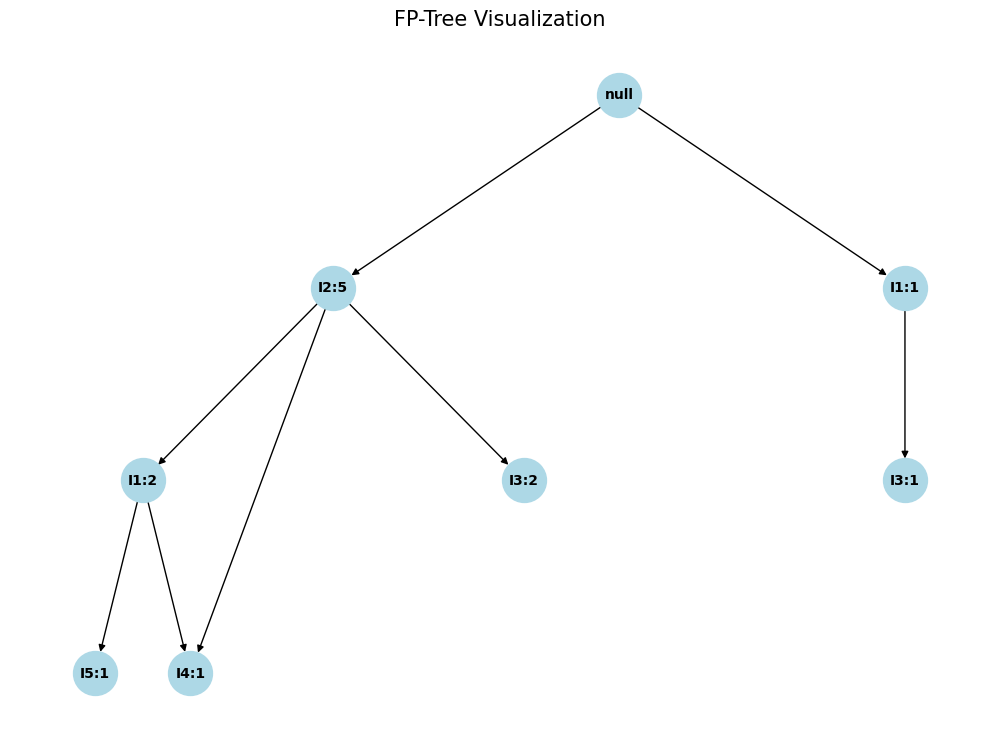


Transaction 7: ['I1', 'I3']
Drawing FP-Tree after Transaction 7:


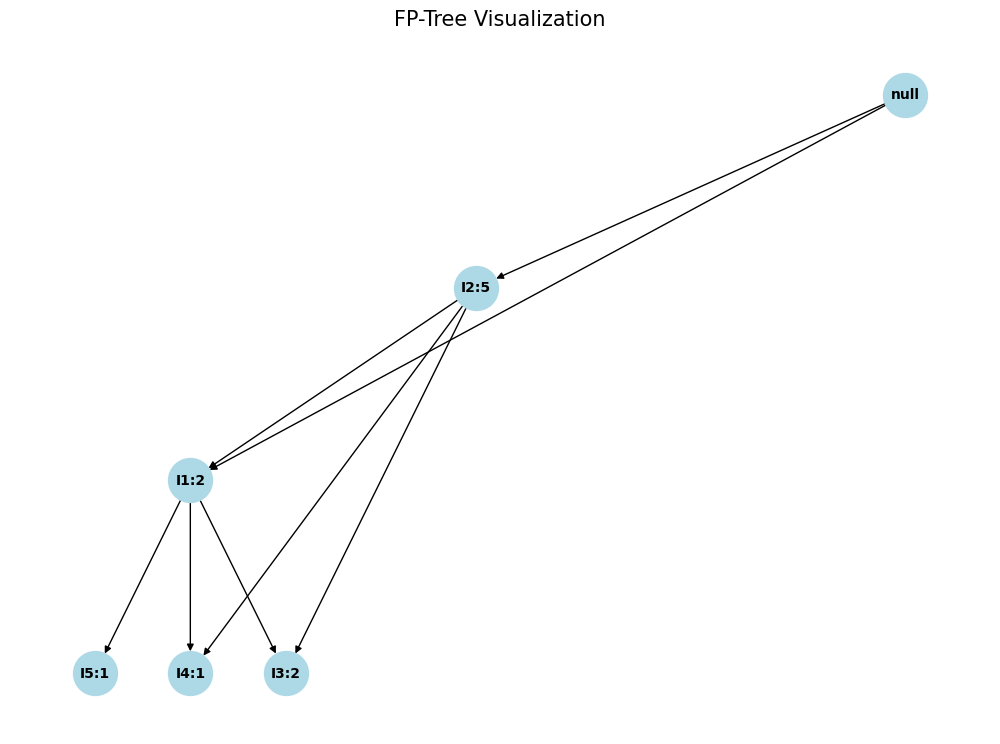


Transaction 8: ['I2', 'I1', 'I3', 'I5']
Drawing FP-Tree after Transaction 8:


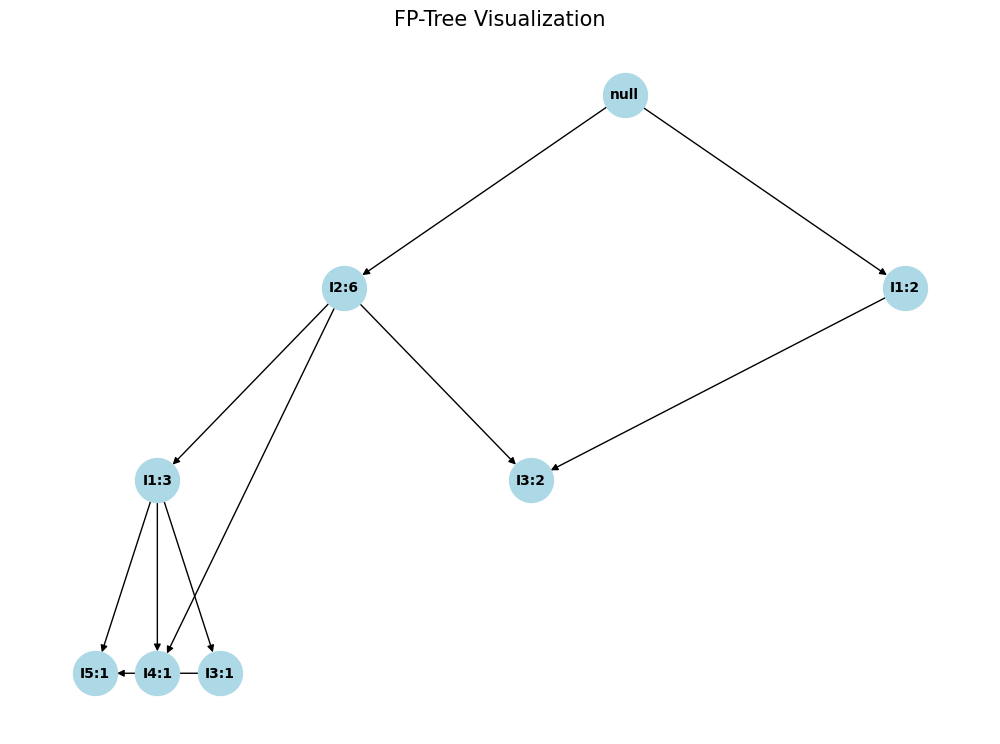


Transaction 9: ['I2', 'I1', 'I3']
Drawing FP-Tree after Transaction 9:


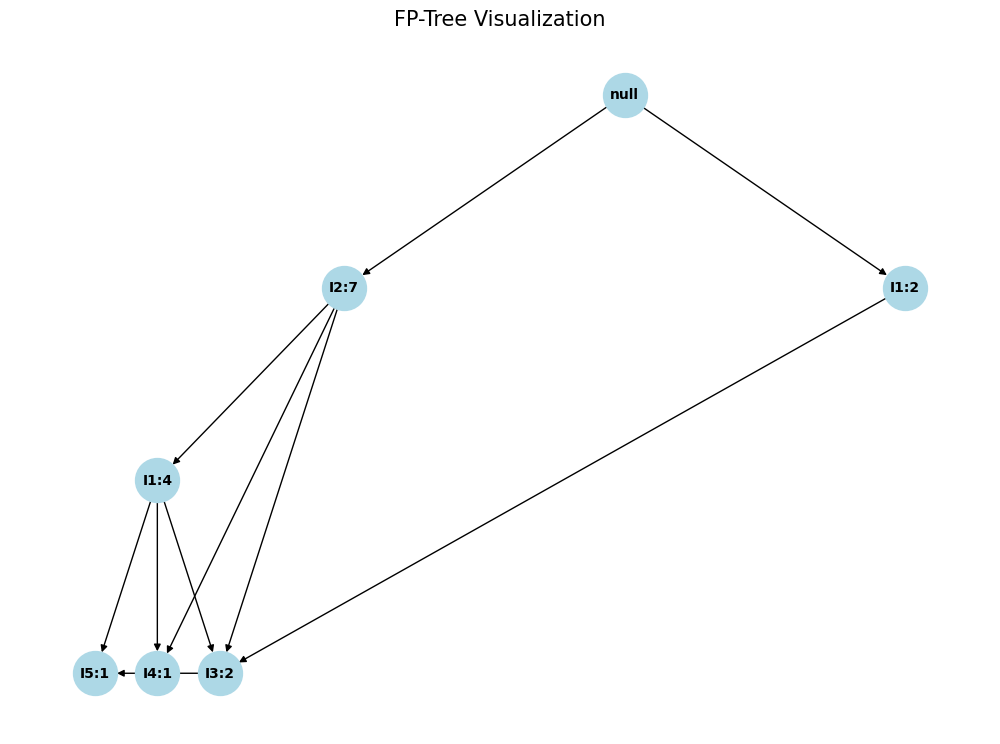


Final FP-Tree Visualization:


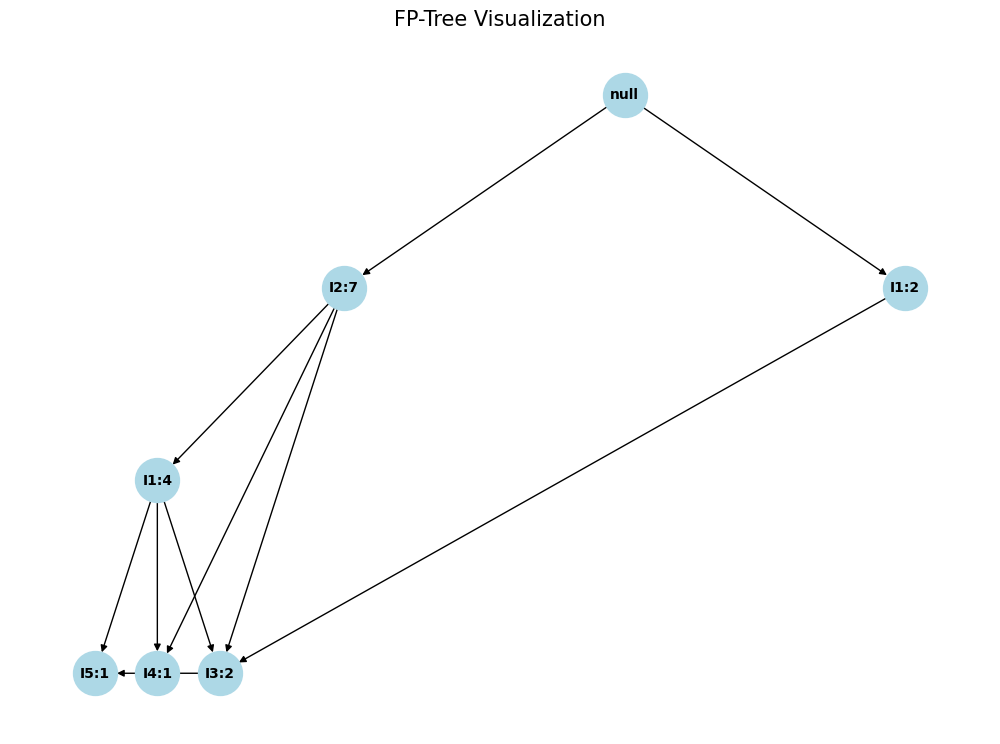

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

# TreeNode Class
class TreeNode:
    def __init__(self, item, count, parent):
        self.item = item
        self.count = count
        self.parent = parent
        self.children = {}

    def increment(self, count):
        self.count += count

# Insert items into the FP-tree
def insert_tree(items, node):
    if len(items) == 0:
        return
    first = items[0]
    if first in node.children:
        node.children[first].increment(1)
    else:
        node.children[first] = TreeNode(first, 1, node)
    remaining_items = items[1:]
    insert_tree(remaining_items, node.children[first])

# Draw FP-Tree using networkx
def draw_tree(root):
    G = nx.DiGraph()

    def add_edges(node, parent_name):
        for child in node.children.values():
            current_name = f"{child.item}:{child.count}"
            G.add_edge(parent_name, current_name)
            add_edges(child, current_name)

    root_name = "null"
    G.add_node(root_name)
    add_edges(root, root_name)

    pos = hierarchy_pos(G, root_name)
    plt.figure(figsize=(9.8, 7))
    nx.draw(G, pos, with_labels=True, arrows=True, node_size=1000, node_color="lightblue", font_size=10, font_weight="bold")
    plt.title("FP-Tree Visualization", fontsize=15)
    plt.show()

# Tree Layout function
def hierarchy_pos(G, root=None, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5):
    pos = {}
    def _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter, pos, parent=None):
        children = list(G.successors(root))
        if not isinstance(G, nx.DiGraph):
            raise TypeError('G must be a DiGraph.')
        if root not in pos:
            pos[root] = (xcenter, vert_loc)
        if len(children) != 0:
            dx = width / len(children)
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G, child, width=dx, vert_gap=vert_gap,
                                     vert_loc=vert_loc-vert_gap, xcenter=nextx, pos=pos, parent=root)
        return pos

    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter, pos)

# Build FP-Tree
def build_fp_tree(transactions, min_support_count):
    item_count = defaultdict(int)

    # First scan to count frequencies
    for transaction in transactions:
        for item in transaction:
            item_count[item] += 1

    # Remove infrequent items
    item_count = {item: count for item, count in item_count.items() if count >= min_support_count}

    # Sort by frequency
    freq_items = sorted(item_count.items(), key=lambda x: (-x[1], x[0]))

    print("\nFP-Table (after support filtering):")
    for item, count in freq_items:
        print(f"Item: {item}, Count: {count}")

    # Map item to position
    item_order = {item: idx for idx, (item, _) in enumerate(freq_items)}

    # Create FP-Tree root
    root = TreeNode('null', 1, None)

    # Insert transactions
    for tidx, transaction in enumerate(transactions):
        ordered_items = [item for item in sorted(transaction, key=lambda x: item_order.get(x, float('inf'))) if item in item_order]
        print(f"\nTransaction {tidx+1}: {ordered_items}")
        insert_tree(ordered_items, root)

        print(f"Drawing FP-Tree after Transaction {tidx+1}:")
        draw_tree(root)

    return root

# Sample Transactions
transactions = [
    ['I1', 'I2', 'I5'],
    ['I2', 'I4'],
    ['I2', 'I3'],
    ['I1', 'I2', 'I4'],
    ['I1', 'I3'],
    ['I2', 'I3'],
    ['I1', 'I3'],
    ['I1', 'I2', 'I3', 'I5'],
    ['I1', 'I2', 'I3']
]

# Take user input for min_support and min_confidence
# min_support = float(input("Enter minimum support (between 0 and 1): "))

# User Input
min_support = 0.22  # 22% minimum support
min_support_count = int(min_support * len(transactions))  # minimum count (on 9 transactions)

# Build and visualize FP-Tree
fp_tree_root = build_fp_tree(transactions, min_support_count)

print("\nFinal FP-Tree Visualization:")
draw_tree(fp_tree_root)

In [4]:
! pip install networkx

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------------ --------------------- 0.8/1.7 MB 7.7 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 4.6 MB/s eta 0:00:00
